# Optimization algorithm search study

In [46]:
PATH_PREFIX = '../../../'
import sys
sys.path.append(PATH_PREFIX)

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
import csv
from utils.plot import *
from utils.fitness_controller import FitnessController
from compress_optim import CompressConfig, load_comp_config, fit_from_vals

In [48]:
NET_TYPE = 'relu'
BASE_PATH = os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_locked/')
SAVE_FILES = {
    'RND_save.csv': 'RND',
    'PSO_save.csv': 'PSO',
    'GA_save.csv': 'GA',
    'BH_save.csv': 'BH',
}

SAVE_PLOTS = True
SAVE_PLOTS_LOC = os.path.join(PATH_PREFIX, 'results/graphs/optimizations')
os.makedirs(SAVE_PLOTS_LOC, exist_ok=True)
SAVE_PLOT_ID = f'{NET_TYPE}_locked'
ACC_TRESHOLD = 0.01

In [49]:
cf = None

with open(os.path.join(BASE_PATH, 'experiment_setting.yaml'), 'r') as config:
    load_comp_config(yaml.safe_load(config))

In [50]:
data = {
    'run': [],
}

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
}

# all dirs with the experiment data
exp_dirs = [name for name in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, name))]

In [51]:
global_fit_cont = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
            target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

for dir in exp_dirs:
    for file in os.listdir(os.path.join(BASE_PATH, dir)):

        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, file))
        global_fit_cont.fit_from_df(save_df, verbose=True)

print(global_fit_cont.targ)

[ 0.99 14.  ]


In [52]:
for dir in exp_dirs:

    data['run'].append(dir)

    for file in os.listdir(os.path.join(BASE_PATH, dir)):
        
        # loading the data
        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, file))

        loc_fit_cont = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
            target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

        # get correct fitness row by current fitness controller
        loc_fit_cont.fit_from_df(save_df, verbose=True)

        save_df = save_df[save_df['accuracy_loss'] < 0.01]

        # saving best found row
        data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]

        key = SAVE_FILES[file]

        if key not in data.keys():
            data[key] = []
        
        data_complete['run'].append(dir)
        data_complete['accuracy'].append(data_row['accuracy'])
        data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
        data_complete['compression'].append(data_row['compression'])
        data_complete['type'].append(key)

        data[key].append(data_row['fitness'])

data = pd.DataFrame(data)
data_complete = pd.DataFrame(data_complete)
global_fit_cont.fit_from_df(data_complete)
data

,run,BH,GA,PSO,RND
0,run7,5.130312,7.212279,3.689826,4.217289
1,run3,3.613883,4.954165,5.639686,3.492417
2,run4,4.647013,4.014653,4.561823,4.352032
3,run10,6.466396,8.249026,6.658773,3.409621
4,run2,3.844704,4.667063,4.709152,3.409623
5,run8,6.945719,3.638344,4.868820,3.713228
6,run9,5.146149,3.948048,6.025715,2.988333
7,run11,6.961167,4.668661,4.381995,3.414201
8,run1,3.618771,8.333123,4.540901,3.270528
9,run5,6.282315,7.250227,4.616164,3.839655


In [53]:
tmp = data_complete[data_complete['type'] == 'GA'].sort_values('compression', ascending=False)
tmp['accuracy_loss'] = tmp['accuracy_loss'] * 100
tmp['accuracy'] = tmp['accuracy'] * 100 
tmp

,run,accuracy,accuracy_loss,compression,type,fitness
33,run1,97.64,0.82,12.331002,GA,8.333123
13,run10,97.66,0.80,12.313442,GA,8.249026
37,run5,97.70,0.76,12.077797,GA,7.250227
1,run7,97.72,0.74,12.067324,GA,7.212279
41,run6,97.52,0.94,11.745982,GA,6.184527
5,run3,97.48,0.98,11.182282,GA,4.954165
17,run2,97.70,0.76,11.005893,GA,4.667063
29,run11,97.86,0.60,11.005618,GA,4.668661
9,run4,98.14,0.32,10.514896,GA,4.014653
25,run9,97.50,0.96,10.460294,GA,3.948048


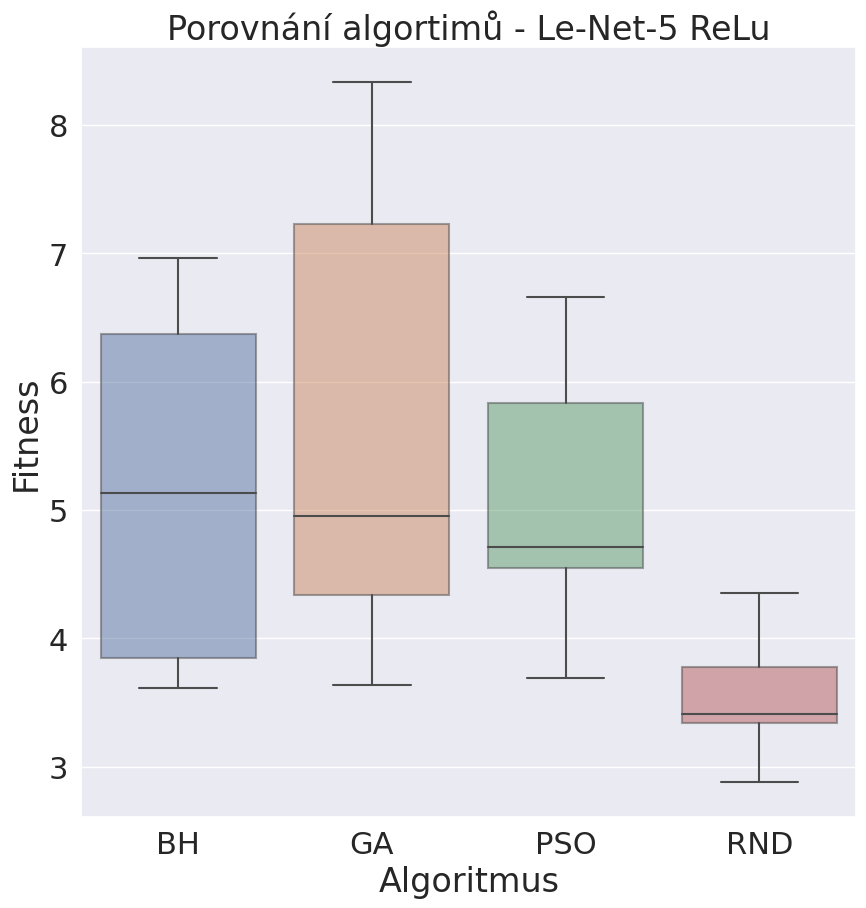

In [54]:
sns.set(style="darkgrid", rc={'figure.figsize': (10, 10)}, font_scale=2)
graph = sns.boxplot(data=data_complete, x='type', y='fitness', boxprops=dict(alpha=0.5)) #  medianprops={"color": "coral"}
graph.set(xlabel = 'Algoritmus', ylabel='Fitness', title=f'Porovnání algortimů - Le-Net-5 {"Tanh" if NET_TYPE == "tanh" else "ReLu"}')

if SAVE_PLOTS:
    graph.get_figure().savefig(os.path.join(SAVE_PLOTS_LOC, f'box_{SAVE_PLOT_ID}.pdf'))

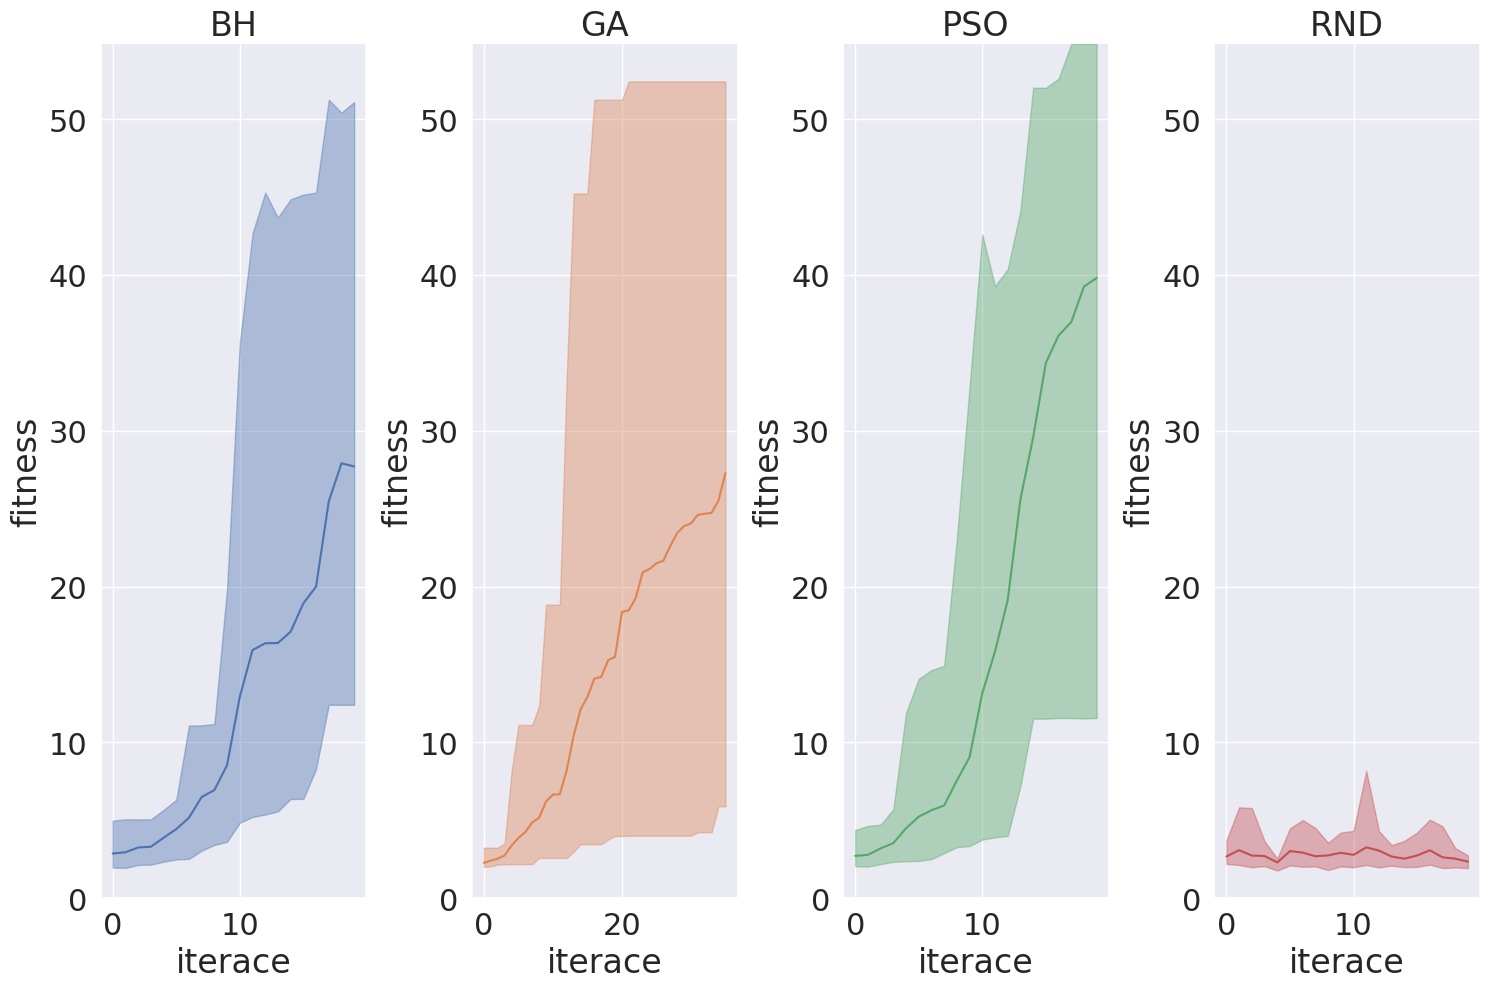

In [55]:
files = {
    'BH': [],
    'GA': [],
    'PSO': [],
    'RND': [],
}

for key in files.keys():
    for i in range(1, 12):
        files[key].append(f'{BASE_PATH}run{i}/{key}_save.csv')

plot_optimalization_progress(files, global_fit_cont)

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'line_{SAVE_PLOT_ID}.pdf'))

In [56]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss'] 
data_complete.loc[len(data_complete.index)] = ['run0', global_fit_cont.targ[0], before_loss - global_fit_cont.targ[0], global_fit_cont.targ[1], 'TARG', 0]
data_complete['accuracy'] *= 100
data_complete['accuracy_loss'] *= 100

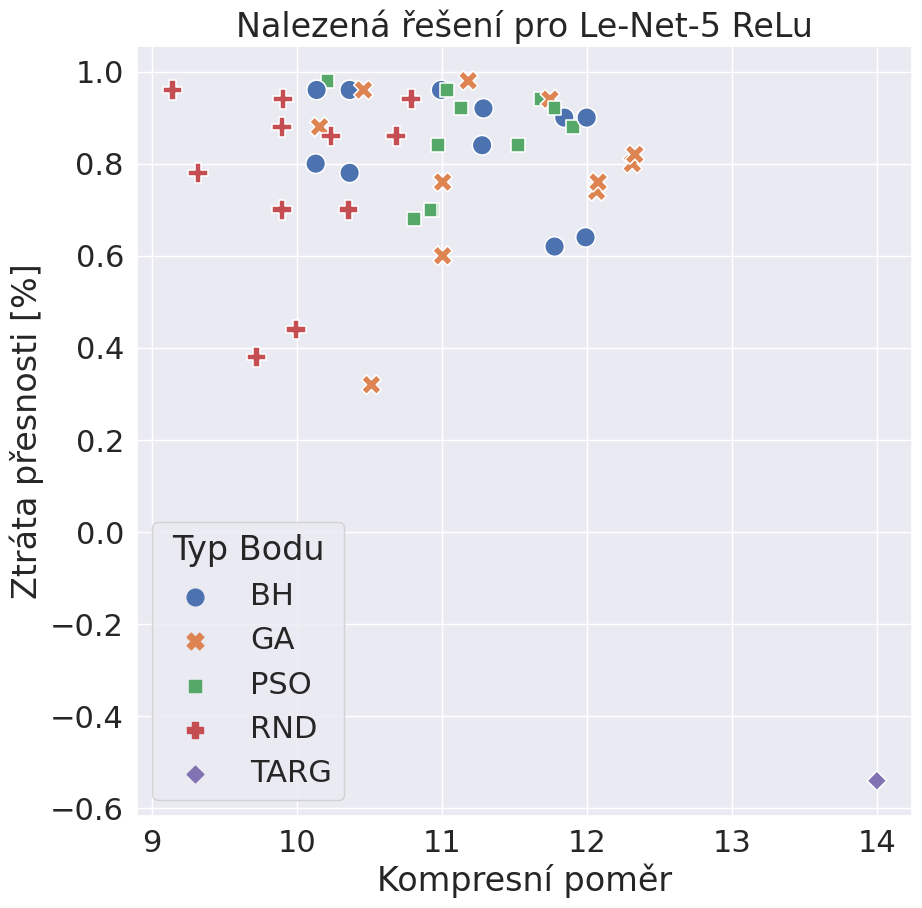

In [57]:
sns.set(rc={'figure.figsize': (10, 10)}, font_scale=2)
ax = sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', hue='type', s=200, style='type')
plt.legend(loc='lower left', title='Typ Bodu', markerscale=2)
ax.set(xlabel='Kompresní poměr', ylabel='Ztráta přesnosti [%]', title=f'Nalezená řešení pro Le-Net-5 {"Tanh" if NET_TYPE == "tanh" else "ReLu"}')
#sns.set_style("whitegrid", {'axes.grid' : False})
#sns.scatterplot(data=data_complete, x='compression', y='accuracy', ax=ax.twinx(), alpha=0)
#plt.gca().invert_yaxis()
#sns.despine(bottom=True, left=True)
#plt.ylabel('Přesnost [%]')
#plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'lenet_scatter_{SAVE_PLOT_ID}.pdf'))